# Segmentation of Indian Traffic

In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q drive/MyDrive/data.zip

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [4]:
# ref.: https://www.geeksforgeeks.org/os-module-python-examples/

def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    
    images = []
    json_file = []
    
    images_dir = '/images'
    json_dir = '/mask'
    
    images_dir_lst = os.listdir(root_dir + images_dir)
    json_dir_lst = os.listdir(root_dir + json_dir)
    
    for img in images_dir_lst:
        image = os.listdir(root_dir + images_dir + os.sep + img)
        for i in image:
            images.append(root_dir + images_dir + os.sep + img + os.sep + i)
    images.sort()
    
    for js in json_dir_lst:
        json = os.listdir(root_dir + json_dir + os.sep + js)
        for j in json:
            json_file.append(root_dir + json_dir + os.sep + js + os.sep + j)
    json_file.sort()
    
    data_df = pd.DataFrame({"images":images, "json":json_file})
    return data_df
    

In [5]:
data_df = return_file_names_df('data')
data_df.head()

,images,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [6]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [7]:
grader_1(data_df)

True

In [8]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [9]:
def return_unique_labels(data_df):
    unique_labels = set()
    
    for i in data_df['json']: # for each file in the column json
        f = open(i)  # read and store all the objects present in that file
        data = json.load(f)
        f.close()

        for j in data['objects']:
            unique_labels.add(j['label']) # compute the unique objects and retrun them

    return unique_labels

In [10]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [11]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [12]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to divide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [13]:
def get_poly(file):
    label = []
    vertexlist = []

    # this function will take a file name as argument
    f = open(file)
    data = json.load(f)
    f.close()

    # it will process all the objects in that file and returns
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    for i in data['objects']:
          label.append(i['label'])
          vertexlist.append([tuple(j) for j in i['polygon']])
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
        
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    w = data['imgWidth']
    
    # height of the image
    h = data['imgHeight']

    return w, h, label, vertexlist

In [14]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

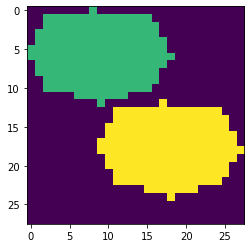

In [15]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [16]:
# ref.: https://www.geeksforgeeks.org/os-module-python-examples/

import re
def compute_masks(data_df):
    mask_path = []
    
    # after you have computed the vertexlist plot that polygone in image like this
    for i in tqdm(data_df['json'].values):
        w, h, label, vertexlist = get_poly(i)
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)

        for j in range(len(label)):
            if (len(vertexlist[j]) > 1):
                img1.polygon(vertexlist[j], fill = label_clr[label[j]])

        img = np.array(img)
        im = Image.fromarray(img[:,:,0])
        if not os.path.isdir('data/output'):
            os.makedirs('data/output')
        
        if not os.path.isdir('data/output/' + i.split('/')[2]):
            os.makedirs('data/output/' + i.split('/')[2])
        
        res = path.join('data/output', i.split('/')[2], i.split('/')[3].split('.')[0] + '.png')
        im.save(res)

        mask_path.append(res)
    
    data_df['mask']= mask_path
    return data_df

In [17]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:18<00:00, 15.51it/s]


,images,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [18]:
# saving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [20]:
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [21]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape,Flatten
from tensorflow.keras.models import Model
import random as rn

In [22]:
from sklearn.model_selection import train_test_split

data = data_df[['images', 'mask']]
X_train, X_test = train_test_split(data, test_size=0.15, random_state=42)

In [23]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [24]:
import imgaug.augmenters as iaa

aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [25]:
import tensorflow
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

def normalize(mask):
    mask = mask/255
    return mask

class Dataset:
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_names, classes, training=True):
        
        self.ids = file_names
        # the paths of images
        self.images_fps = [i for i in self.ids['images']]
        # the paths of segmentation images
        self.masks_fps = [i for i in self.ids['mask']]
        # giving labels for each class
        self.class_values = classes
        self.training = training
      
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(512, 512),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = normalize(image)

        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED) 
        mask = cv2.resize(mask,(512, 512),interpolation=cv2.INTER_NEAREST)

        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if self.training:
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)

In [26]:
class Dataloder(tensorflow.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [27]:
# Dataset for train images
Classes = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,
            'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,
            'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,
            'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,
            'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,
            'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,
            'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190, 'train':200}
CLASSES = list(np.unique(list(Classes.values())))         

train_dataset = Dataset(X_train, classes=CLASSES)
test_dataset  = Dataset(X_test, classes=CLASSES)

BATCH_SIZE = 5
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 21)

(5, 512, 512, 3)


In [29]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet(backbone_name='resnet34', encoder_weights='imagenet', decoder_use_batchnorm =True, classes=21, activation='softmax', decoder_filters=(512,256,128,64,32), encoder_freeze=False, input_shape=(512,512,3))
model.summary()

85524480/85521592 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_34[0][0]          
___________________________

In [30]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

iou_score.threshold = 0.5
model.compile(optim, focal_loss, metrics=[iou_score])

In [31]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=5, validation_data=test_dataloader)

Epoch 1/5
681/681 [==============================] - 666s 947ms/step - loss: 0.7623 - iou_score: 0.4623 - val_loss: 0.8515 - val_iou_score: 0.4226
Epoch 2/5
681/681 [==============================] - 619s 908ms/step - loss: 0.6157 - iou_score: 0.5699 - val_loss: 0.5853 - val_iou_score: 0.5975
Epoch 3/5
681/681 [==============================] - 626s 918ms/step - loss: 0.5658 - iou_score: 0.5950 - val_loss: 0.5580 - val_iou_score: 0.5991
Epoch 4/5
681/681 [==============================] - 612s 898ms/step - loss: 0.5398 - iou_score: 0.6172 - val_loss: 0.5406 - val_iou_score: 0.6194
Epoch 5/5
681/681 [==============================] - 616s 904ms/step - loss: 0.5220 - iou_score: 0.6340 - val_loss: 0.5388 - val_iou_score: 0.6173


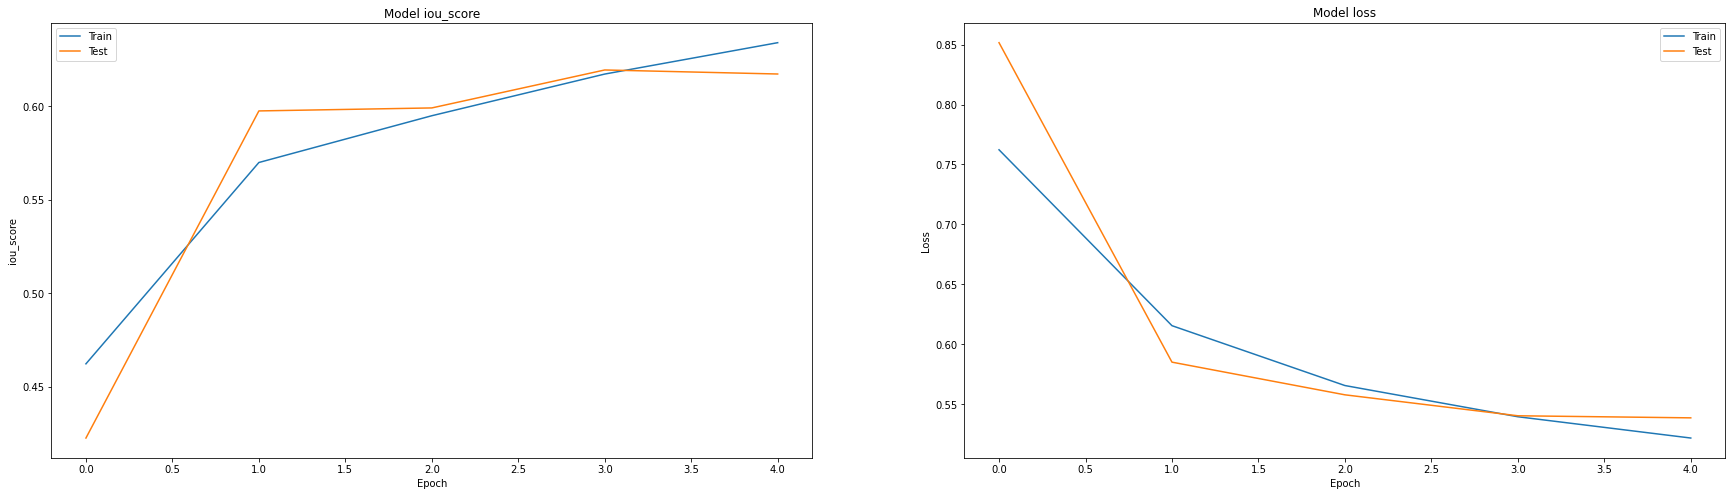

In [32]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 8))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

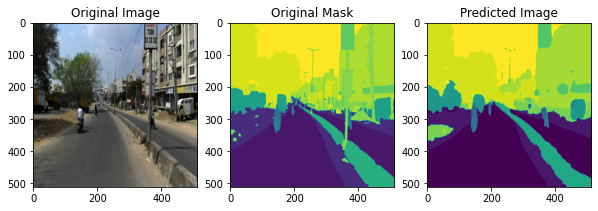

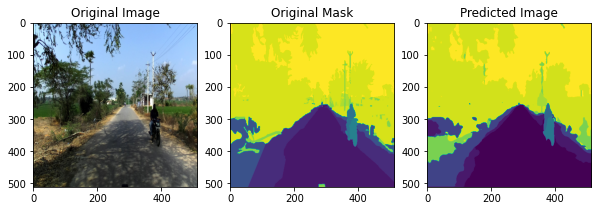

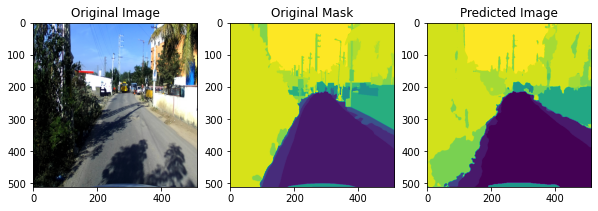

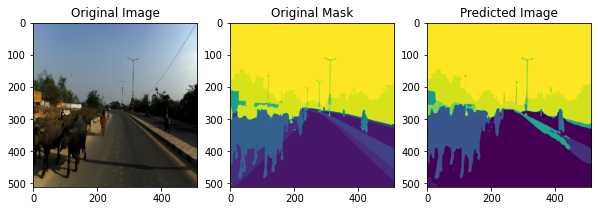

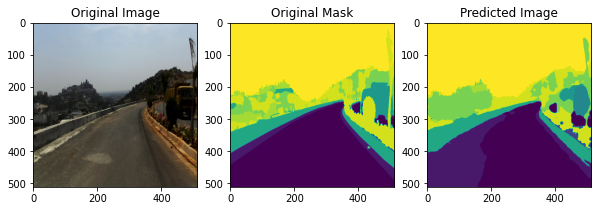

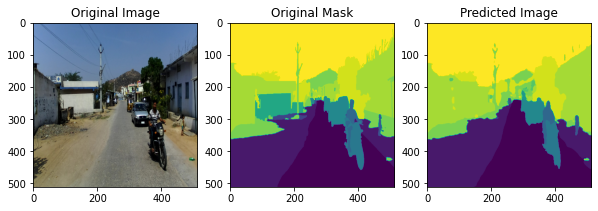

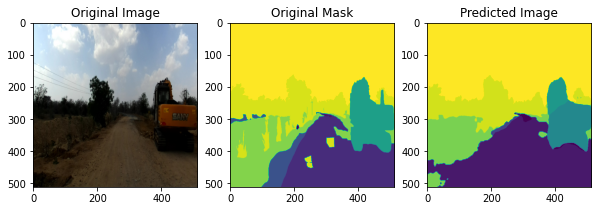

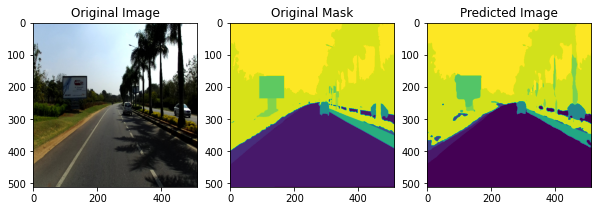

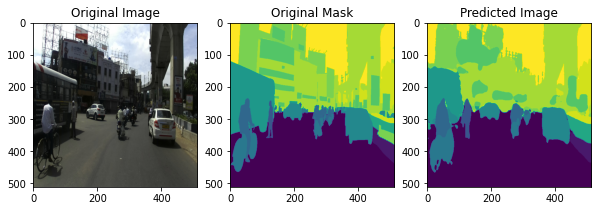

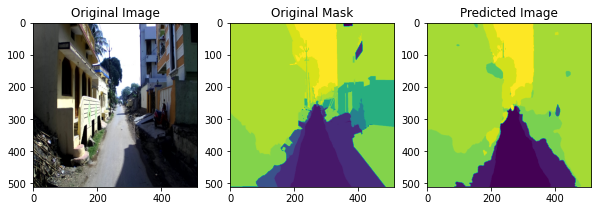

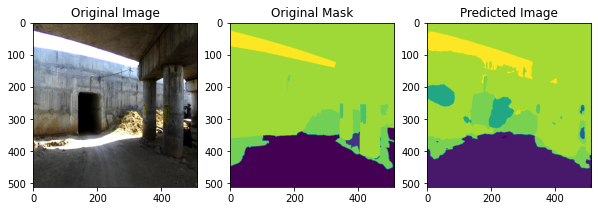

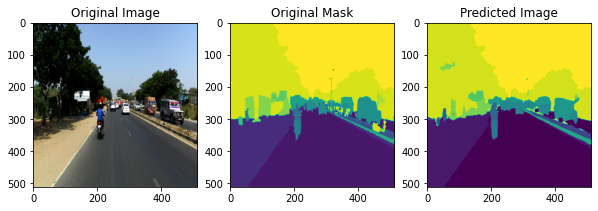

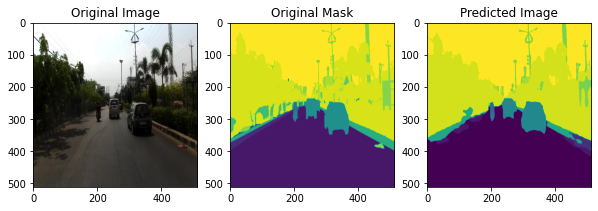

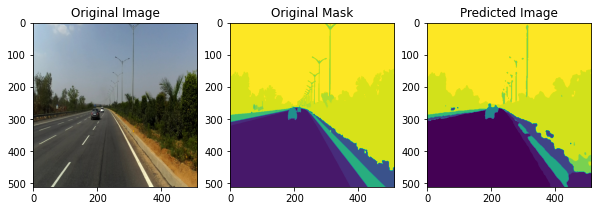

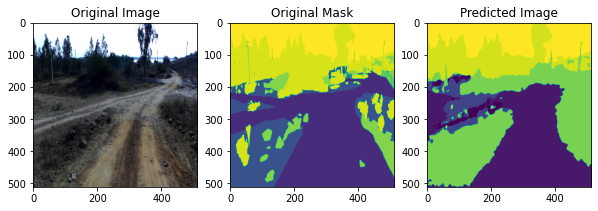

In [33]:
for j,i in enumerate(X_test.values.tolist()[0:15]):
        image = cv2.imread(i[0], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (512,512), cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=normalize(image)
        
        mask  = cv2.imread(i[1], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (512,512), cv2.INTER_NEAREST)
        mask = mask//10
        
        predicted=model(image[np.newaxis,:,:,:])
        pred=tf.argmax(predicted,axis=-1)
        
        plt.figure(figsize=(10,6))
        plt.subplot(131)
        plt.title('Original Image')
        plt.imshow(image)
        
        plt.subplot(132)
        plt.title('Original Mask')
        plt.imshow(mask)
        
        plt.subplot(133)
        plt.title('Predicted Image')
        plt.imshow(pred[0,:,:])
        
        plt.show()

# Task 3: Training CANet

In [34]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [35]:
tf.keras.backend.clear_session()
class convolutional_block(tf.keras.layers.Layer):

    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="convolutional_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
        self.conv1 = Conv2D(filters=self.F1, kernel_size=1, padding='same')
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters=self.F2, kernel_size=self.kernel, padding='same', strides=(self.stride, self.stride))
        self.bn2 = BatchNormalization()
        
        self.conv3 = Conv2D(filters=self.F3, kernel_size=1, padding='same')
        self.bn3 = BatchNormalization()

        self.convskip = Conv2D(filters=self.F3, kernel_size=self.kernel, padding='same', strides=(self.stride, self.stride))
        self.bnskip = BatchNormalization()

        self.activation = Activation('relu')
        self.add = Add()

    def call(self, X):
        
        # Convolutional Block 1
        conv_1 = self.conv1(X)
        bn_1 = self.bn1(conv_1)
        activation1 = self.activation(bn_1)
        
        # Convolutional Block 2
        conv_2 = self.conv2(activation1)
        bn_2 = self.bn2(conv_2)
        activation2 = self.activation(bn_2)

        # Convolutional Block 3
        conv_3 = self.conv3(activation2)
        bn_3 = self.bn3(conv_3)

        # Skip Connection
        conv_skip = self.convskip(X)
        bn_skip = self.bnskip(conv_skip)
        activation_skip = self.activation(bn_skip)

        X = self.add([bn_3, activation_skip])
        
        return X

In [36]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        
        self.conv1 = Conv2D(filters=self.F1, kernel_size=1, padding='same')
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(filters=self.F2, kernel_size=self.kernel, padding='same')
        self.bn2 = BatchNormalization()
        
        self.conv3 = Conv2D(filters=self.F3, kernel_size=1, padding='same')
        self.bn3 = BatchNormalization()
        
        self.activation = Activation('relu')
        self.add = Add()
        
    def call(self, X):
        # write the architecutre that was mentioned above
        
        # Convolutional Block 1
        conv_1 = self.conv1(X)
        bn_1 = self.bn1(conv_1)
        activation1 = self.activation(bn_1)
        
        # Convolutional Block 2
        conv_2 = self.conv2(activation1)
        bn_2 = self.bn2(conv_2)
        activation2 = self.activation(bn_2)

        # Convolutional Block 3
        conv_3 = self.conv3(activation2)
        bn_3 = self.bn3(conv_3)

        X = self.add([X, bn_3])
        
        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [37]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, input_size, output_size, name="global_flow"):
        super().__init__(name=name)
        self.input_size = input_size
        self.output_size = output_size
        
        self.conv = Conv2D(filters=64, kernel_size=1, padding='same')
        self.batch = BatchNormalization()
        self.activation = Activation('relu')
        self.global_avg = GlobalAveragePooling2D()
        self.upsample = tf.keras.layers.UpSampling2D(size=(self.input_size, self.output_size), interpolation='bilinear')
        
    def call(self, X):
        # implement the global flow operation
        global_avg = self.global_avg(X)
        batch_norm = self.batch(global_avg)
        activation = self.activation(batch_norm)
        
        exp = tf.expand_dims(activation, axis=1)
        exp = tf.expand_dims(exp, axis=1)
        
        convo = self.conv(exp)
        
        X = self.upsample(convo)
        
        return X

In [38]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        
        self.concat = Concatenate()
        self.avgpool = AveragePooling2D()
        self.upsample = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.activation1 = Activation('relu')
        self.activation2 = Activation('sigmoid')

        self.conv1 = Conv2D(filters=64, kernel_size=3, padding='same')
        self.conv2 = Conv2D(filters=64, kernel_size=3, padding='same')
        self.conv3 = Conv2D(filters=64, kernel_size=1, padding='same')
        self.conv4 = Conv2D(filters=64, kernel_size=1, padding='same')

        self.mul = Multiply()
        self.add = Add()
        
    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        
        # Context Fusion Module
        concatinate = self.concat([INP, FLOW])
        avg_pool = self.avgpool(concatinate)
        conv_1 = self.conv1(avg_pool)
        conv_2 = self.conv2(conv_1)
        
        # Context Refinement Module
        conv_3 = self.conv3(conv_2)
        activation_1 = self.activation1(conv_3)
        conv_4 = self.conv4(activation_1)
        activation_2 = self.activation2(conv_4)
        
        multiplication = self.mul([conv_2, activation_2])
        addition = self.add([conv_2, multiplication])
        
        X = self.upsample(addition)
        
        return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [39]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        
        self.batch = BatchNormalization()
        self.global_avg = GlobalAveragePooling2D()
        self.upsample = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.conv1 = Conv2D(filters=32, kernel_size=3, padding='same')
        self.conv2 = Conv2D(filters=32, kernel_size=1, padding='same')

        self.activation = Activation('sigmoid')
        self.mul = Multiply()
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        conv_1 = self.conv1(X)
        
        global_pool = self.global_avg(conv_1)
        exp = tf.expand_dims(global_pool, axis=1)
        exp = tf.expand_dims(exp, axis=1)
        conv_2 = self.conv2(exp)
        bn = self.batch(conv_2)
        activation = self.activation(bn)
        
        multiply = self.mul([conv_1, activation])
        FSM_Conv_T = self.upsample(multiply)
        
        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [40]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.add = Add()

        self.conv1 = Conv2D(filters=32, kernel_size=(7,1), padding='same')
        self.conv2 = Conv2D(filters=32, kernel_size=(1,7), padding='same')
        self.conv3 = Conv2D(filters=32, kernel_size=(1,7), padding='same')
        self.conv4 = Conv2D(filters=32, kernel_size=(7,1), padding='same')
        self.conv5 = Conv2D(filters=32, kernel_size=3, padding='same')
        
    def call(self, X):
        # please implement the above mentioned architecture
        conv_1 = self.conv1(X)
        conv_2 = self.conv2(conv_1)
        conv_3 = self.conv3(X)
        conv_4 = self.conv4(conv_3)
        
        addition_1 = self.add([conv_2, conv_4])
        conv_5 = self.conv5(addition_1)
        
        X = self.add([addition_1, conv_5])
        
        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [ ]:
X_input = Input(shape=(128,128,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)

(None, 64, 64, 64)


* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [41]:
# write the complete architecutre
X_input = Input(shape=(512,512,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

# 1st Convolution block followed by one identity block
conv_1 = convolutional_block(stride=2, name= 'convolutional_block_1')(X)
identity_1 = identity_block(name = 'identity_block_1')(conv_1)

# 2nd Convolution block followed by 2 identity block
conv_2 = convolutional_block(stride=2, name= 'convolutional_block_2')(identity_1)
identity_21 = identity_block(name = 'identity_block_21')(conv_2)
identity_22 = identity_block(name = 'identity_block_22')(identity_21)

# 3rd Convolution block followed by 3 identity block
conv_3 = convolutional_block(stride=1, name= 'convolutional_block_3')(identity_22)
identity_31 = identity_block(name = 'identity_block_31')(conv_3)
identity_32 = identity_block(name = 'identity_block_32')(identity_31)
identity_33 = identity_block(name = 'identity_block_33')(identity_32)

# 4th Convolution block followed by 4 identity block
conv_4 = convolutional_block(stride=1, name= 'convolutional_block_4')(identity_33)
identity_41 = identity_block(name = 'identity_block_41')(conv_4)
identity_42 = identity_block(name = 'identity_block_42')(identity_41)
identity_43 = identity_block(name = 'identity_block_43')(identity_42)
identity_44 = identity_block(name = 'identity_block_44')(identity_43)

# Global flow
global_flow = global_flow(identity_44.shape[1], identity_44.shape[2])(identity_44)

# 1st context flow
context_flow_1 = context_flow(name='context_flow_1')([identity_44, global_flow])

# 2nd context flow
context_flow_2 = context_flow(name='context_flow_2')([identity_44, context_flow_1])

# 3rd context flow
context_flow_3 = context_flow(name='context_flow_3')([identity_44, context_flow_2])

# sum
add = Add()([global_flow, context_flow_1, context_flow_2, context_flow_3])

# Feature Selection Module
fsm_1 = fsm()(add)

# Decoder Network
# Adapted Global Convolutional Network(AGCN)
agcn_1 = agcn()(conv_1)

# concat
concat = Concatenate()([fsm_1, agcn_1])

# Convolution later
conv_5 = Conv2D(filters=21, kernel_size=1, padding='same', activation='relu')(concat)

# Upsampling
upsample = UpSampling2D((4,4), interpolation='bilinear')(conv_5)

# output
output = Activation('softmax')(upsample)

model = Model(inputs = X_input, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           bn_conv1[0][0]                   
______________________________________________________________________________________________

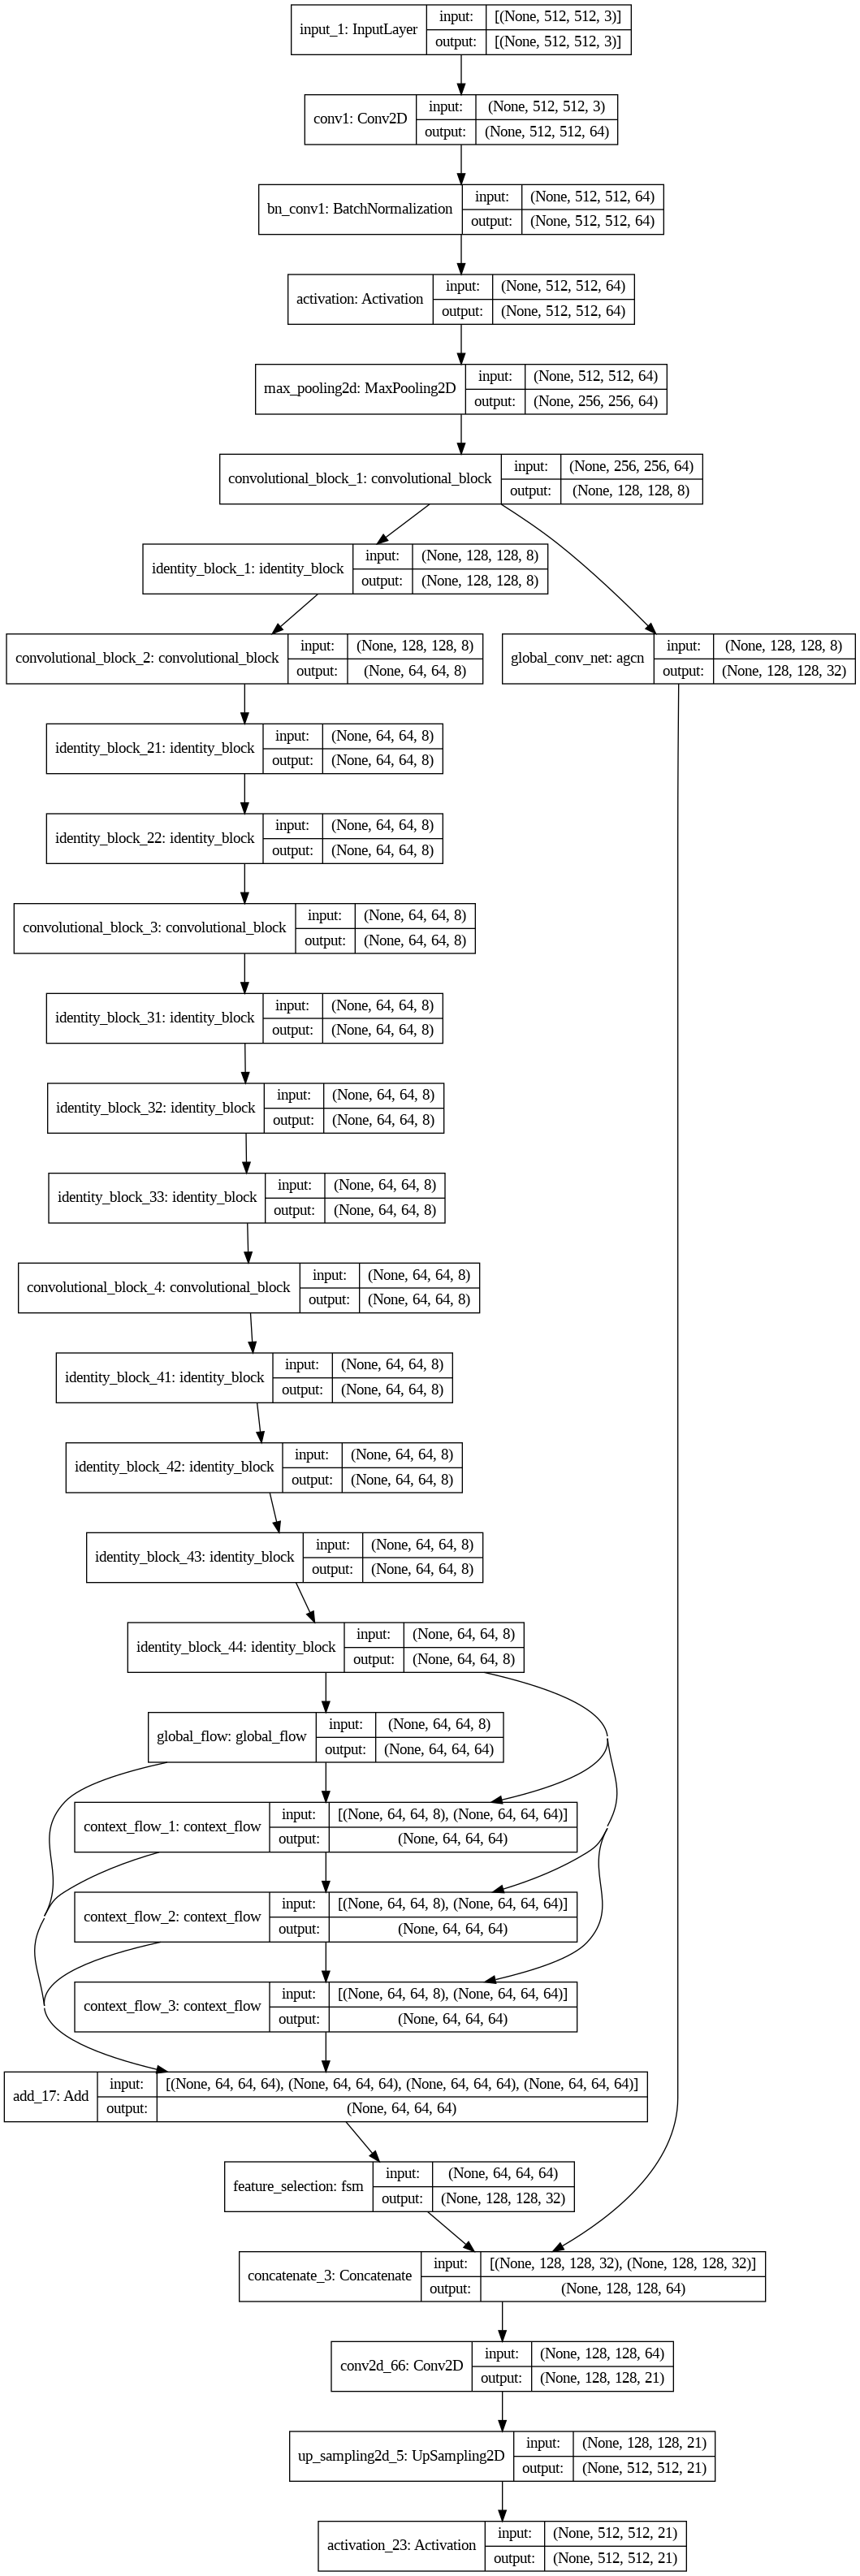

In [42]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [43]:
import segmentation_models as sm
from segmentation_models.metrics import IOUScore

optim = tf.keras.optimizers.Adam(0.0001)
focal_loss = sm.losses.cce_dice_loss

iou_score.threshold = 0.5
model.compile(optim, focal_loss, metrics=[iou_score])

In [44]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=6, validation_data=test_dataloader)

Epoch 1/6
681/681 [==============================] - 568s 820ms/step - loss: 0.9473 - iou_score: 0.1600 - val_loss: 0.9043 - val_iou_score: 0.2713
Epoch 2/6
681/681 [==============================] - 560s 822ms/step - loss: 0.8898 - iou_score: 0.3034 - val_loss: 0.8715 - val_iou_score: 0.3425
Epoch 3/6
681/681 [==============================] - 563s 826ms/step - loss: 0.8673 - iou_score: 0.3491 - val_loss: 0.8406 - val_iou_score: 0.3837
Epoch 4/6
681/681 [==============================] - 566s 831ms/step - loss: 0.8482 - iou_score: 0.3676 - val_loss: 0.8336 - val_iou_score: 0.3804
Epoch 5/6
681/681 [==============================] - 564s 828ms/step - loss: 0.8347 - iou_score: 0.3737 - val_loss: 0.8220 - val_iou_score: 0.3630
Epoch 6/6
681/681 [==============================] - 569s 836ms/step - loss: 0.8235 - iou_score: 0.3799 - val_loss: 0.8130 - val_iou_score: 0.3811


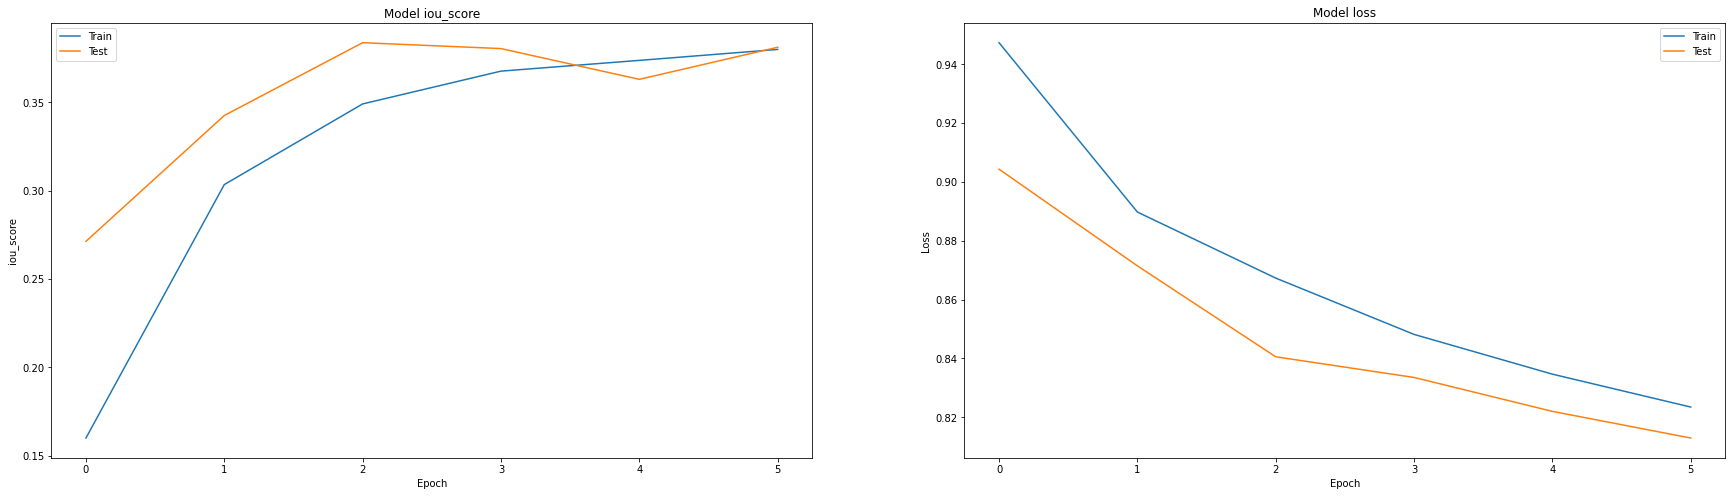

In [45]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 8))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

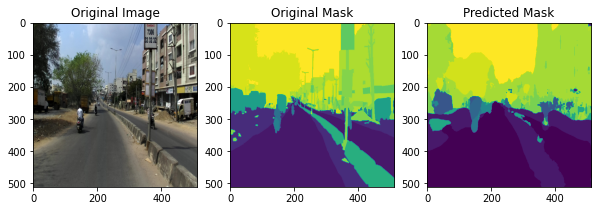

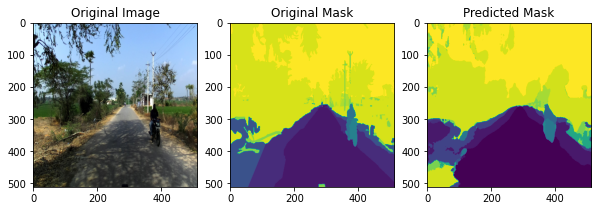

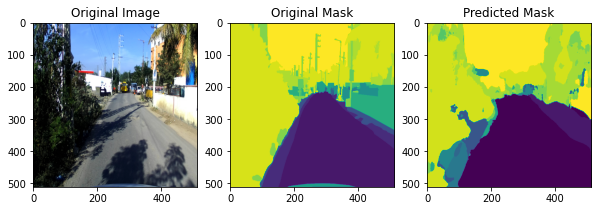

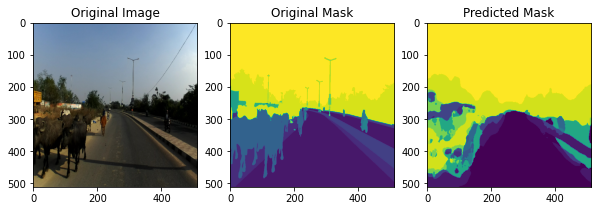

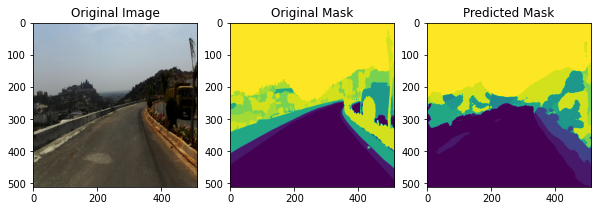

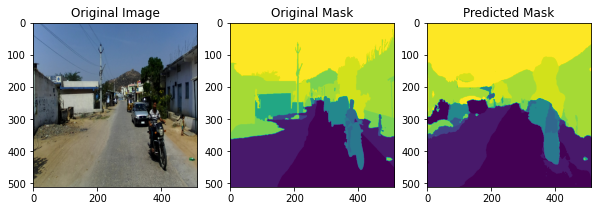

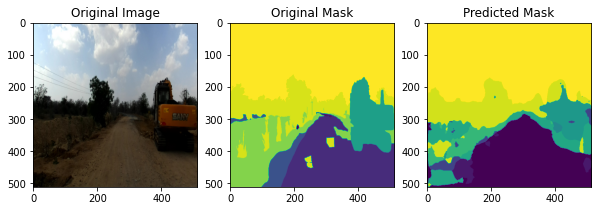

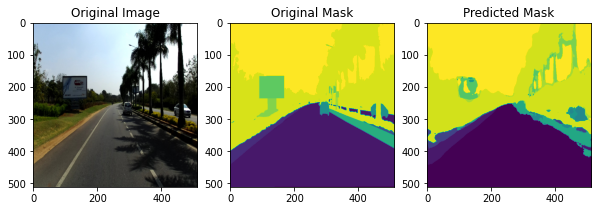

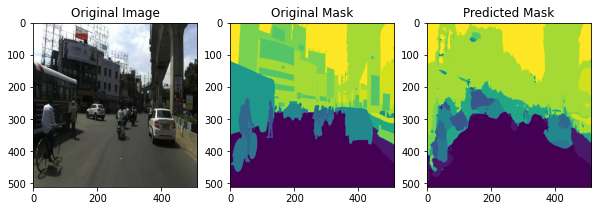

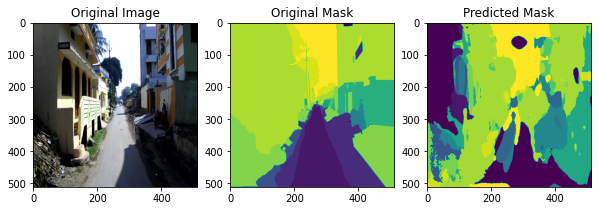

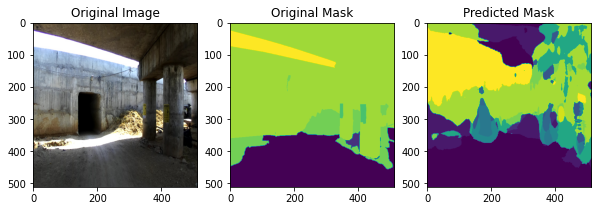

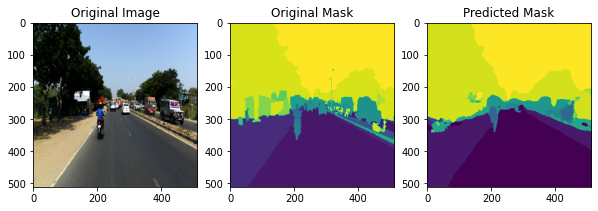

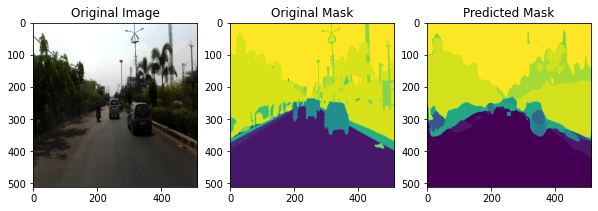

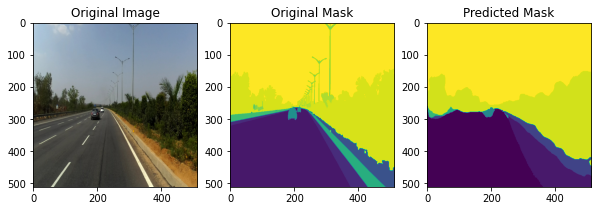

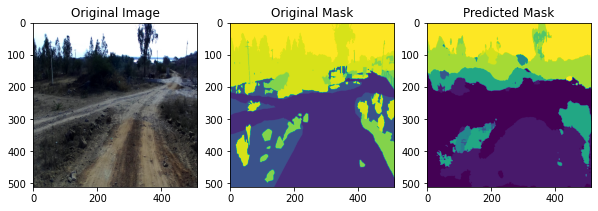

In [46]:
for j,i in enumerate(X_test.values.tolist()[0:15]):
        image = cv2.imread(i[0], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (512,512), cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=normalize(image)
        
        mask  = cv2.imread(i[1], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (512,512), cv2.INTER_NEAREST)
        mask = mask//10
        
        predicted=model(image[np.newaxis,:,:,:])
        pred=tf.argmax(predicted,axis=-1)
        
        plt.figure(figsize=(10,6))
        plt.subplot(131)
        plt.title('Original Image')
        plt.imshow(image)
        
        plt.subplot(132)
        plt.title('Original Mask')
        plt.imshow(mask)
        
        plt.subplot(133)
        plt.title('Predicted Mask')
        plt.imshow(pred[0,:,:])
        
        plt.show()

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations